# Preliminary operation and Import Packages

In [52]:
import cv2
import os
import glob2 as glob
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

Let us now explore some `enanchment` and `pre-processing` techniques to improve the overall quality and interpretation of images

## Gamma correction

Gamma is an important but seldom understood characteristic of virtually all digital imaging systems. It defines the relationship between a pixel's numerical value and its actual luminance. Without gamma, shades captured by digital cameras wouldn't appear as they did to our eyes (on a standard monitor). 

In [ ]:
# Function for apply gamma correction 

def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

In [ ]:
im_gamma = adjust_gamma(im, gamma=0.6)

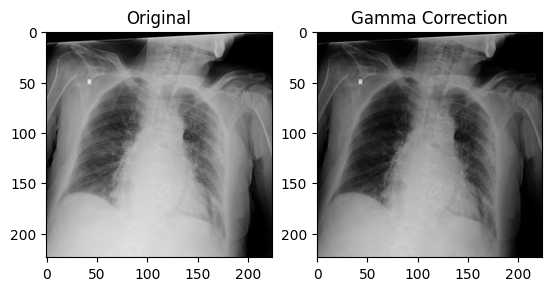

In [ ]:
plt.subplot(1,2,1); plt.imshow(im, cmap="gray"); plt.title('Original')
plt.subplot(1,2,2); plt.imshow(im_gamma, cmap="gray"); plt.title('Gamma Correction')
plt.show()

##  Improved Adaptive Gamma Correction

As an efficient image contrast enhancement (CE) tool, adaptive gamma correction (AGC) was previously proposed by relating gamma parameter with cumulative distribution function (CDF) of the pixel gray levels within an image. ACG deals well with most dimmed images, but fails for globally bright images and the dimmed images with local bright regions. Such two categories of brightness-distorted images are universal in real scenarios, such as improper exposure and white object regions. In order to attenuate such deficiencies, here we propose an improved AGC algorithm. The novel strategy of negative images is used to realize CE of the bright images, and the gamma correction modulated by truncated CDF is employed to enhance the dimmed ones. As such, local over-enhancement and structure distortion can be alleviated. Both qualitative and quantitative experimental results show that our proposed method yields consistently good CE results. https://arxiv.org/abs/1709.04427

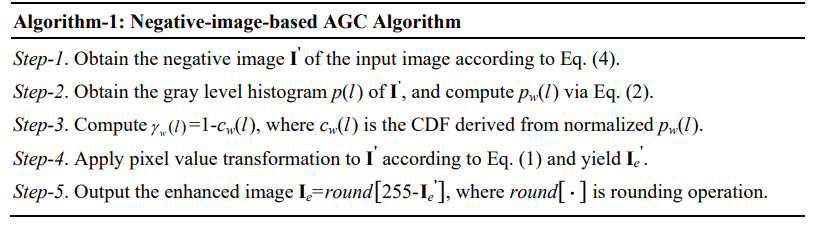

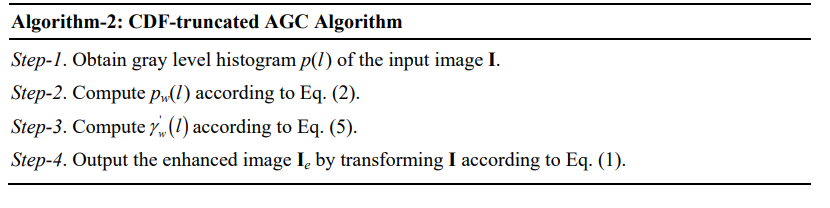

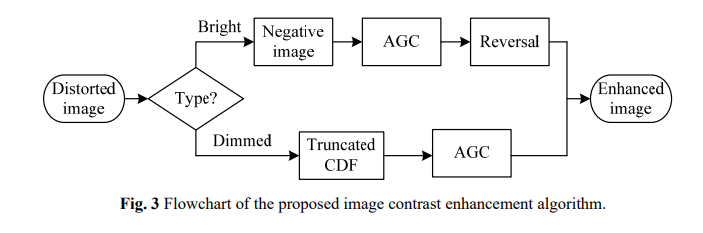

### Functions

The following functions implement the Adaptive Gamma Correction algorithm:

The image_agcwd function is the heart of Adaptive Gamma Correction. The function receives an image and the parameters *a* and *truncated_cdf*, which determine the shape of the correction. The function calculates the histogram of the image, normalises the cumulative distribution and the probability distribution. It then performs a transformation on the probability distribution, calculates the inverse cumulative distribution and uses it to correct the brightness of the image.

Finally, the **process_bright** and **process_dimmed** functions invoke the **image_agcwd** function with the appropriate parameters to process the bright and dark images, respectively.

In [53]:
def image_agcwd(img, a=0.25, truncated_cdf=False):
    h,w = img.shape[:2]
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf.max()
    prob_normalized = hist / hist.sum()

    unique_intensity = np.unique(img)
    intensity_max = unique_intensity.max()
    intensity_min = unique_intensity.min()
    prob_min = prob_normalized.min()
    prob_max = prob_normalized.max()
    
    pn_temp = (prob_normalized - prob_min) / (prob_max - prob_min)
    pn_temp[pn_temp>0] = prob_max * (pn_temp[pn_temp>0]**a)
    pn_temp[pn_temp<0] = prob_max * (-((-pn_temp[pn_temp<0])**a))
    prob_normalized_wd = pn_temp / pn_temp.sum() # normalize to [0,1]
    cdf_prob_normalized_wd = prob_normalized_wd.cumsum()
    
    if truncated_cdf: 
        inverse_cdf = np.maximum(0.5,1 - cdf_prob_normalized_wd)
    else:
        inverse_cdf = 1 - cdf_prob_normalized_wd
    
    img_new = img.copy()
    for i in unique_intensity:
        img_new[img==i] = np.round(255 * (i / 255)**inverse_cdf[i])
   
    return img_new

def process_bright(img):
    img_negative = 255 - img
    agcwd = image_agcwd(img_negative, a=0.25, truncated_cdf=False)
    reversed = 255 - agcwd
    return reversed

def process_dimmed(img):
    agcwd = image_agcwd(img, a=0.75, truncated_cdf=True)
    return agcwd

This function applies the *Adaptive Gamma Correction* over the whole train dataset

1) Reading images from the input directory and creating the output directory if one does not exist.
2) Conversion of each image from BGR format to YCrCb.
3) Calculation of image intensity average Y (brightness channel).
4) Determination of image brightness:
    - If the intensity average is below a threshold, the image is considered "dark" and is processed with the process_dimmed function.
    - If the average intensity is above a threshold, the image is considered "bright" and is processed with the process_bright function.
    - Otherwise, the image is considered 'correct' and is not processed.
5) Saving the processed images in the output directory.

In [ ]:
def apply_AGCWD(input_dir, output_dir):
    img_paths = glob.glob(input_dir+'*')
    total_count= 0
    dimmed_count= 0
    brighted_count = 0
    for path in img_paths:
        total_count +=1
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Convert to BGR
        # img = cv2.resize(img, (224,224)) # Resize to 224x224
        name = path.split('\\')[-1].split('.')[0]
        
        # Extract intensity component of the image
        YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        Y = YCrCb[:,:,0]
        # Determine whether image is bright or dimmed
        threshold = 0.3
        exp_in = 112 # Expected global average intensity 
        M,N = img.shape[:2]
        mean_in = np.sum(Y/(M*N)) 
        t = (mean_in - exp_in)/ exp_in
        
        # Process image for gamma correction
        img_output = None
        if t < -threshold: # Dimmed Image
            dimmed_count += 1
            # print (name + ": Dimmed")
            result = process_dimmed(Y)
            YCrCb[:,:,0] = result
            img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
        elif t > threshold:
            brighted_count += 1
            # print (name + ":Bright") # Bright Image
            result = process_bright(Y)
            YCrCb[:,:,0] = result
            img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
        else:
            # print('None')
            img_output = img
            img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2GRAY)

        cv2.imwrite(output_dir+name+'.png', img_output)
    print("Numero totale di immagini processate: {}".format(total_count))
    print("Numero di immagini dimmed: {}".format(dimmed_count))
    print("Numero di immagini brighted: {}".format(brighted_count))
    return

### Some examples of AGC application

In [ ]:
img_paths = 'C:/Users/marco/Desktop/Local_Documents/data/train/3a81faf3.jpg'
img_paths = glob.glob(input_dir+'*')
img = cv2.imread(img_paths)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (224,224))
name = img_paths.split('\\')[-1].split('.')[0]

# Extract intensity component of the image
YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
Y = YCrCb[:,:,0]
# Determine whether image is bright or dimmed
threshold = 0.3
exp_in = 112 # Expected global average intensity 
M,N = img.shape[:2]
mean_in = np.sum(Y/(M*N)) 
t = (mean_in - exp_in)/ exp_in

# Process image for gamma correction
img_output = None
if t < -threshold: # Dimmed Image
    res = "Oscura"
    print (name + ": Oscurato")
    result = process_dimmed(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
elif t > threshold:
    res = "Schiarisce"
    print (name + ": Schiarito") # Bright Image
    result = process_bright(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
    img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2GRAY)
else:
    res = 'Non effettua Gamma Correction'
    img_output = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.subplot(1,2,1); plt.imshow(img, cmap="gray"); plt.title('Original')
plt.subplot(1,2,2); plt.imshow(img_output, cmap="gray"); plt.title(res)
plt.show()

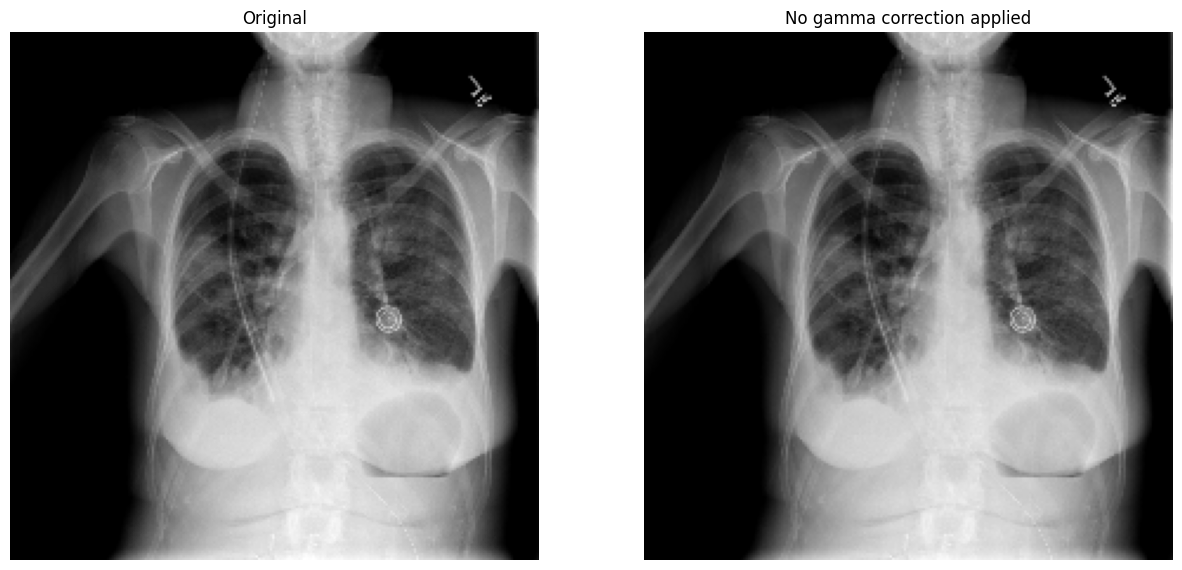

In [82]:
img_paths = 'C:/Users/marco/Desktop/Local_Documents/data/COVIDx-nosplit/train/6fd45bf7-e07a-445e-b853-f871d9281630.png'
# output_dir = 'C:/Users/marco/Desktop/Local_Documents/data/train_AGCWD/'
img = cv2.imread(img_paths)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (224,224))
name = img_paths.split('\\')[-1].split('.')[0]

# Extract intensity component of the image
YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
Y = YCrCb[:,:,0]
# Determine whether image is bright or dimmed
threshold = 0.3
exp_in = 112 # Expected global average intensity 
M,N = img.shape[:2]
mean_in = np.sum(Y/(M*N)) 
t = (mean_in - exp_in)/ exp_in

# Process image for gamma correction
img_output = None
if t < -threshold: # Dimmed Image
    res = "Oscura"
    print (name + ": Oscurato")
    result = process_dimmed(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
elif t > threshold:
    res = "Schiarisce"
    print (name + ": Schiarito") # Bright Image
    result = process_bright(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
    img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2GRAY)
else:
    res = 'No gamma correction applied'
    img_output = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# cv2.imwrite(output_dir+name+'.png', img_output)

fig, ax = plt.subplots()

# Rimuovi gli assi x e y
ax.remove()
# Rimuovi i ticker degli assi
# ax.xaxis.set_ticks_position('none')
# ax.yaxis.set_ticks_position('none')
plt.subplot(1,2,1); plt.imshow(img, cmap="gray"); plt.title('Original')
plt.subplot(1,2,1).axis('off')
plt.subplot(1,2,2); plt.imshow(img_output, cmap="gray"); plt.title(res)
plt.subplot(1,2,2).axis('off')
ax.axis('off')
plt.show()

C:/Users/marco/Desktop/Local_Documents/data/COVIDx-nosplit/train/4b6cf439-a0a3-485f-8de9-950ee632cbca: Bright


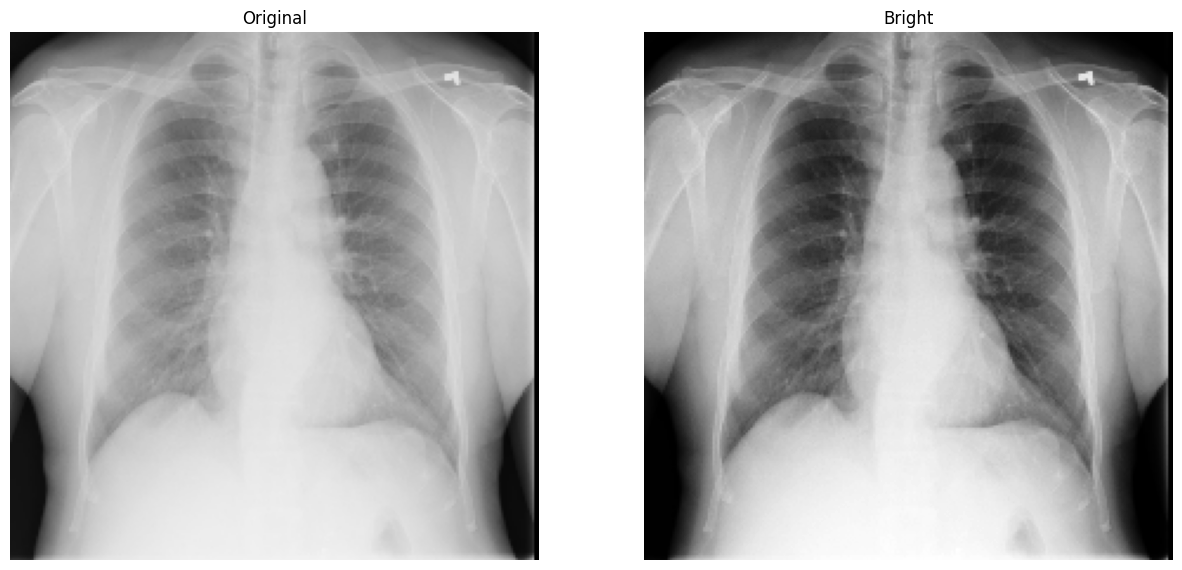

In [83]:
img_paths = 'C:/Users/marco/Desktop/Local_Documents/data/COVIDx-nosplit/train/4b6cf439-a0a3-485f-8de9-950ee632cbca.png'
output_dir = 'C:/Users/marco/Desktop/Local_Documents/data/train_AGCWD/'
img = cv2.imread(img_paths)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (224,224))
name = img_paths.split('\\')[-1].split('.')[0]

# Extract intensity component of the image
YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
Y = YCrCb[:,:,0]
# Determine whether image is bright or dimmed
threshold = 0.3
exp_in = 112 # Expected global average intensity 
M,N = img.shape[:2]
mean_in = np.sum(Y/(M*N)) 
t = (mean_in - exp_in)/ exp_in

# Process image for gamma correction
img_output = None
if t < -threshold: # Dimmed Image
    res = "Dimmed"
    print (name + ": Oscurato")
    result = process_dimmed(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
elif t > threshold:
    res = "Bright"
    print (name + ": Bright") # Bright Image
    result = process_bright(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
    img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2GRAY)
else:
    res = 'Non effettua Gamma Correction'
    img_output = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# cv2.imwrite(output_dir+name+'.png', img_output)
plt.subplot(1,2,1); plt.imshow(img, cmap="gray"); plt.title('Original')
plt.subplot(1,2,1).axis('off')
plt.subplot(1,2,2); plt.imshow(img_output, cmap="gray"); plt.title(res)
plt.subplot(1,2,2).axis('off')
plt.show()

62158463-7464-4781-86b2-f43cf3f1833d: Oscurato


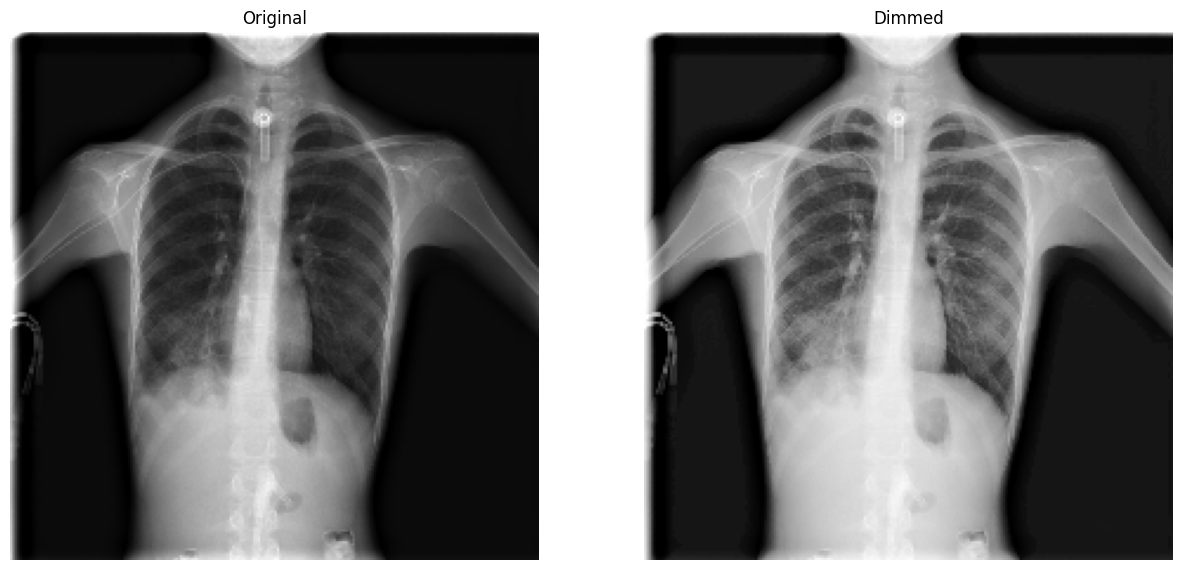

In [110]:
img_paths ="C:\\Users\\marco\\Desktop\\Local_Documents\\data\\COVIDx-nosplit\\train\\62158463-7464-4781-86b2-f43cf3f1833d.png"
# output_dir = 'C:/Users/marco/Desktop/Local_Documents/data/train_AGCWD/'
img = cv2.imread(img_paths)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (224,224))
name = img_paths.split('\\')[-1].split('.')[0]

# Extract intensity component of the image
YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
Y = YCrCb[:,:,0]
# Determine whether image is bright or dimmed
threshold = 0.3
exp_in = 112 # Expected global average intensity 
M,N = img.shape[:2]
mean_in = np.sum(Y/(M*N)) 
t = (mean_in - exp_in)/ exp_in

# Process image for gamma correction
img_output = None
if t < -threshold: # Dimmed Image
    res = "Dimmed"
    print (name + ": Oscurato")
    result = process_dimmed(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
elif t > threshold:
    res = "Brighted"
    print (name + ": Schiarito") # Bright Image
    result = process_bright(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
    img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2GRAY)
else:
    res = 'No gamma correction applied'
    img_output = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# cv2.imwrite(output_dir+name+'.png', img_output)

fig, ax = plt.subplots()

# Rimuovi gli assi x e y
ax.remove()
# Rimuovi i ticker degli assi
# ax.xaxis.set_ticks_position('none')
# ax.yaxis.set_ticks_position('none')
plt.subplot(1,2,1); plt.imshow(img, cmap="gray"); plt.title('Original')
plt.subplot(1,2,1).axis('off')
plt.subplot(1,2,2); plt.imshow(img_output, cmap="gray"); plt.title(res)
plt.subplot(1,2,2).axis('off')
ax.axis('off')
plt.show()

## Image pre-processing (crop)

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7658227/pdf/41598_2020_Article_76550.pdf

Data pre-processing details:

The COVIDx dataset was used to train all tested deep neural network architectures.
As a pre-processing step, the chest CXR images were **cropped** (top 8% of the image) prior to training in order to mitigate commonly-found embedded textual information in the CXR images.

### Functions

In [10]:
def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]

In [11]:
def process_and_save_images(dataset_dir, output_dir, size, top_percent=0.08, crop=True):
    if not os.path.exists(dataset_dir):
        print(f"Nessuna directory trovata: {dataset_dir}")
        return
    classes = os.listdir(dataset_dir)
    saves = 0
    fail = 0 
    for class_name in classes:
        # print(class_name)
        class_dir = os.path.join(dataset_dir, class_name)
        # print(class_dir)
        if not os.path.isdir(class_dir):
            continue
        output_class_dir = os.path.join(output_dir, class_name)
        # print(output_class_dir)
        image_files = os.listdir(class_dir)
        # print(image_files)
        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)
            img = cv2.imread(image_path)
            # print(img.shape)
            img = crop_top(img, percent=top_percent)
            if crop:
                img = central_crop(img)
            img = cv2.resize(img, (size, size))
            output_path = os.path.join(output_class_dir, image_file)
            # print(output_path)
            save = cv2.imwrite(output_path, img)
            if save:
                # print(f"Immagine salvata: {output_path}")
                saves +=1
            else:
                # (f"Immagine non saltata: {output_path}")
                fail +=1
    print('Numero totali di immagini procesate e salvate',  saves)
    print('Numero di immagini non salvate', fail)


In [8]:
dataset_dir = 'C:/Users/marco/Desktop/Local_Documents/data/COVIDx-nosplit/test'
output_dir = 'C:/Users/marco/Desktop/Local_Documents/data/COVIDx-splitted-resized/test_process'
process_and_save_images(dataset_dir=dataset_dir, output_dir=output_dir, size=1024, top_percent=0.08)

Numero totali di immagini procesate e salvate 0
Numero di immagini non salvate 0


### Some examples of pre-processing applications

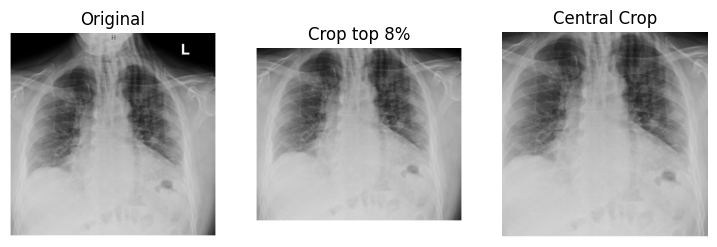

In [118]:
img_3 = central_crop(img_2)
img_path = "C:\\Users\\marco\\Desktop\\Local_Documents\\data\\COVIDx-nosplit\\train\\1-s2.0-S0735675720302746-gr1_lrg.jpg"
img = cv2.imread(img_path)
plt.imshow(img)
img_2 = crop_top(img)
plt.imshow(img_2)
img_3 = central_crop(img_2)
plt.imshow(img_3)plt.imshow(img_3)

fig, ax = plt.subplots()

# Rimuovi gli assi x e y
ax.remove()
# Rimuovi i ticker degli assi
# ax.xaxis.set_ticks_position('none')
# ax.yaxis.set_ticks_position('none')
plt.subplot(1,3,1); plt.imshow(img, cmap="gray"); plt.title('Original')
plt.subplot(1,3,1).axis('off')
plt.subplot(1,3,2); plt.imshow(img_2, cmap="gray"); plt.title('Crop top 8%')
plt.subplot(1,3,2).axis('off')
plt.subplot(1,3,3); plt.imshow(img_3, cmap="gray"); plt.title('Central Crop')
plt.subplot(1,3,3).axis('off')
plt.show()

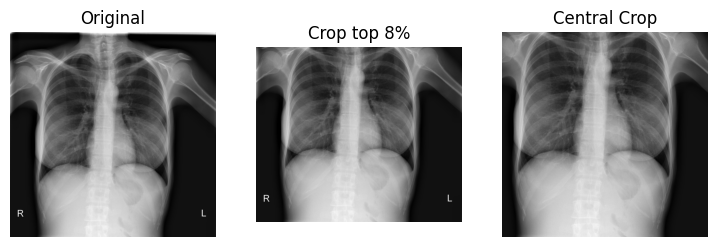

In [122]:
img_path = "C:\\Users\\marco\\Desktop\\Local_Documents\\data\\COVIDx-nosplit\\train\\03dedd9f-7e97-42dd-99aa-afcb09e0395a.png"
img = cv2.imread(img_path)
plt.imshow(img)
img_2 = crop_top(img)
plt.imshow(img_2)
img_3 = central_crop(img_2)
plt.imshow(img_3)


fig, ax = plt.subplots()

# Rimuovi gli assi x e y
ax.remove()
# Rimuovi i ticker degli assi
# ax.xaxis.set_ticks_position('none')
# ax.yaxis.set_ticks_position('none')
plt.subplot(1,3,1); plt.imshow(img, cmap="gray"); plt.title('Original')
plt.subplot(1,3,1).axis('off')
plt.subplot(1,3,2); plt.imshow(img_2, cmap="gray"); plt.title('Crop top 8%')
plt.subplot(1,3,2).axis('off')
plt.subplot(1,3,3); plt.imshow(img_3, cmap="gray"); plt.title('Central Crop')
plt.subplot(1,3,3).axis('off')
plt.show()

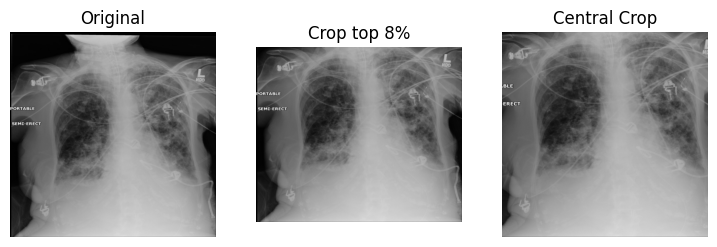

In [130]:
img_path = "C:\\Users\\marco\\Desktop\\Local_Documents\\data\\COVIDx-nosplit\\train\\3b2d5952-ecd3-4e79-9ecc-908adde0ab99.png"
img = cv2.imread(img_path)
plt.imshow(img)
img_2 = crop_top(img)
plt.imshow(img_2)
img_3 = central_crop(img_2)
plt.imshow(img_3)

fig, ax = plt.subplots()

# Rimuovi gli assi x e y
ax.remove()
# Rimuovi i ticker degli assi
# ax.xaxis.set_ticks_position('none')
# ax.yaxis.set_ticks_position('none')
plt.subplot(1,3,1); plt.imshow(img, cmap="gray"); plt.title('Original')
plt.subplot(1,3,1).axis('off')
plt.subplot(1,3,2); plt.imshow(img_2, cmap="gray"); plt.title('Crop top 8%')
plt.subplot(1,3,2).axis('off')
plt.subplot(1,3,3); plt.imshow(img_3, cmap="gray"); plt.title('Central Crop')
plt.subplot(1,3,3).axis('off')
plt.show()

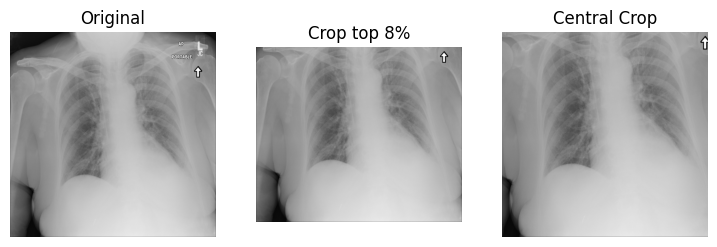

In [134]:
img_path = "C:\\Users\\marco\\Desktop\\Local_Documents\\data\\COVIDx-nosplit\\train\\3eccadbe-e821-4487-afe7-2bc5f2ee5774.png"
img = cv2.imread(img_path)
plt.imshow(img)
img_2 = crop_top(img)
plt.imshow(img_2)
img_3 = central_crop(img_2)
plt.imshow(img_3)


fig, ax = plt.subplots()

# Rimuovi gli assi x e y
ax.remove()
# Rimuovi i ticker degli assi
# ax.xaxis.set_ticks_position('none')
# ax.yaxis.set_ticks_position('none')
plt.subplot(1,3,1); plt.imshow(img, cmap="gray"); plt.title('Original')
plt.subplot(1,3,1).axis('off')
plt.subplot(1,3,2); plt.imshow(img_2, cmap="gray"); plt.title('Crop top 8%')
plt.subplot(1,3,2).axis('off')
plt.subplot(1,3,3); plt.imshow(img_3, cmap="gray"); plt.title('Central Crop')
plt.subplot(1,3,3).axis('off')
plt.show()

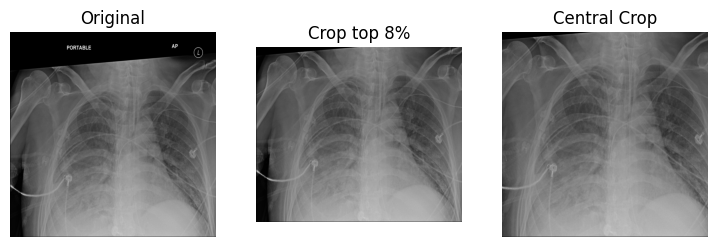

In [139]:
img_path = "C:\\Users\\marco\\Desktop\\Local_Documents\\data\\COVIDx-nosplit\\train\\bd8f8b0b-a89b-42f5-b92c-c0a152c6c1f2.png"
img = cv2.imread(img_path)
plt.imshow(img)
img_2 = crop_top(img)
plt.imshow(img_2)
img_3 = central_crop(img_2)
plt.imshow(img_3)

fig, ax = plt.subplots()

# Rimuovi gli assi x e y
ax.remove()
# Rimuovi i ticker degli assi
# ax.xaxis.set_ticks_position('none')
# ax.yaxis.set_ticks_position('none')
plt.subplot(1,3,1); plt.imshow(img, cmap="gray"); plt.title('Original')
plt.subplot(1,3,1).axis('off')
plt.subplot(1,3,2); plt.imshow(img_2, cmap="gray"); plt.title('Crop top 8%')
plt.subplot(1,3,2).axis('off')
plt.subplot(1,3,3); plt.imshow(img_3, cmap="gray"); plt.title('Central Crop')
plt.subplot(1,3,3).axis('off')
plt.show()